Info    : Reading 'domain.msh'...
Info    : 11 entities
Info    : 91 nodes
Info    : 141 elements
Info    : Done reading 'domain.msh'
Info    : Reading 'domain.msh'...
Info    : 11 entities
Info    : 243 nodes
Info    : 413 elements
Info    : Done reading 'domain.msh'
Info    : Reading 'domain.msh'...
Info    : 11 entities
Info    : 848 nodes
Info    : 1554 elements
Info    : Done reading 'domain.msh'
Info    : Reading 'domain.msh'...
Info    : 11 entities
Info    : 3158 nodes
Info    : 6032 elements
Info    : Done reading 'domain.msh'
Info    : Reading 'domain.msh'...
Info    : 11 entities
Info    : 11996 nodes
Info    : 23429 elements
Info    : Done reading 'domain.msh'
Info    : Reading 'domain.msh'...
Info    : 11 entities
Info    : 47050 nodes
Info    : 92975 elements
Info    : Done reading 'domain.msh'
Info    : Reading 'domain.msh'...
Info    : 11 entities
Info    : 185779 nodes
Info    : 369313 elements                                               
Info    : Done reading 'doma

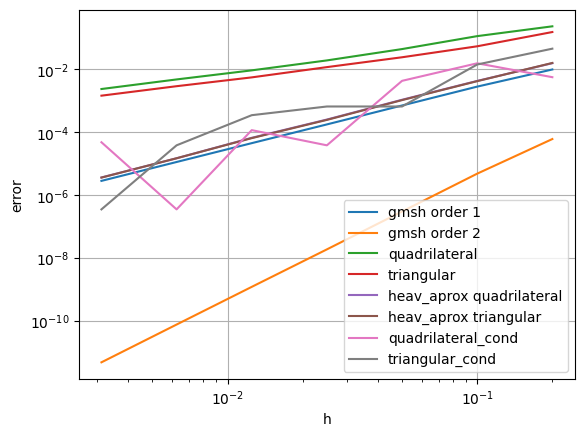

                               0.2       0.1      0.05     0.025    0.0125    0.00625    0.003125
------------------------  --------  --------  --------  --------  --------  ---------  ----------
gmsh order 1              9.96e-03  2.84e-03  7.14e-04  1.79e-04  4.54e-05   1.14e-05    2.87e-06
gmsh order 2              6.13e-05  4.87e-06  3.05e-07  1.91e-08  1.23e-09   7.79e-11    4.91e-12
quadrilateral             2.34e-01  1.14e-01  4.43e-02  1.93e-02  9.34e-03   4.81e-03    2.38e-03
triangular                1.54e-01  5.43e-02  2.43e-02  1.18e-02  5.59e-03   2.93e-03    1.47e-03
heav_aprox quadrilateral  1.58e-02  4.31e-03  1.08e-03  2.55e-04  6.71e-05   1.50e-05    3.68e-06
heav_aprox triangular     1.61e-02  4.24e-03  1.06e-03  2.49e-04  6.55e-05   1.50e-05    3.65e-06
quadrilateral_cond        5.66e-03  1.57e-02  4.34e-03  3.87e-05  1.18e-04   3.56e-07    4.85e-05
triangular_cond           4.57e-02  1.43e-02  6.64e-04  6.64e-04  3.51e-04   3.87e-05    3.56e-07


In [21]:
from dolfinx import fem, io, geometry
from dolfinx.mesh import (locate_entities, create_rectangle, CellType, meshtags)
import dolfinx.cpp as _cpp
from dolfinx.io import gmshio
from ufl import Measure, pi, conditional, le, ge,dx
from mpi4py import MPI
from matplotlib import cm, pyplot as plt
import numpy as np, sys, os
import time
import gmsh
import time
from mesh_disk import generate_mesh
from tabulate import tabulate

final_directory = os.path.join(os.getcwd(), r'Files - area')
if not os.path.exists(final_directory): os.makedirs(final_directory)

def tag_subdomains(msh, subdomains): # Identifies and marks subdomains accoring to locator function
    cell_indices, cell_markers = [], [] #List for facet indices and respective markers
    fdim = msh.topology.dim
    for (marker, locator) in subdomains:
        cells = locate_entities(msh, fdim, locator)
        cell_indices.append(cells)
        cell_markers.append(np.full_like(cells, marker))
    cell_indices = np.hstack(cell_indices).astype(np.int32)
    cell_markers = np.hstack(cell_markers).astype(np.int32)
    sorted_cells = np.argsort(cell_indices)
    cell_tag = meshtags(msh, fdim, cell_indices[sorted_cells], cell_markers[sorted_cells]) 
    return cell_tag

# ------------ unstructured meshes built with gmsh ------------------------

h_list = [0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125]
e_list = []
for mesh_order in [1, 2]:
    err = []
    for h in h_list:
        # Mesh parameters
        radius = 0.2
        Lx = 1.0; Ly = 1.0
        # Mesh generation
        comm = MPI.COMM_WORLD
        file_name = "domain.msh"
        generate_mesh(file_name, radius, Lx, Ly, h, mesh_order)
        msh, cell_tags, _ = gmshio.read_from_msh(file_name, comm, rank=0, gdim=2)
        with io.XDMFFile(comm, final_directory+'/mesh'+str(h)+'order'+str(mesh_order)+'.xdmf', "w") as file:
            file.write_mesh(msh)
        # Area 
        dx = Measure("dx", domain=msh, subdomain_data=cell_tags)
        one = fem.Constant(msh, 1.0)
        area = 1 - np.pi*radius**2
        err.append(np.abs(area - fem.assemble_scalar(fem.form(one*dx(1)))))
    e_list.append(err)  
    
# ------------ structured meshes with binary mapping approach ------------------------

tol = 1e-8
def phi(x):
    return np.sqrt((x[0] - 0.5)**2 + (x[1]-0.5)**2) - radius
subdomains = [(1, lambda x: phi(x) >= tol), 
                (0, lambda x: phi(x) <= tol)]

N_list = [5,10,20,40,80,160,320]
for type in ['quadrilateral', 'crossed']:
    err = []
    for N in N_list:
        comm = MPI.COMM_WORLD
        if type == 'quadrilateral':
            msh = create_rectangle(comm=MPI.COMM_WORLD,
                                    points=((0.0, 0.0), (Lx, Ly)), n=(N, N),
                                    cell_type=CellType.quadrilateral)
        else:
            msh = create_rectangle(comm=MPI.COMM_WORLD,
                                    points=((0.0, 0.0), (Lx, Ly)), n=(N, N),
                                    cell_type=CellType.triangle, diagonal = _cpp.mesh.DiagonalType.crossed)

        cell_tag = tag_subdomains(msh, subdomains)

        Q = fem.FunctionSpace(msh, ("DG", 0))
        k = fem.Function(Q)
        k.x.array[:] = 0
        k.x.array[cell_tag.find(1)] = 1

        with io.XDMFFile(comm, final_directory+'/mesh'+str(N)+str(type)+'.xdmf', "w") as file:
                    file.write_mesh(msh)
                    file.write_function(k)

        dx = Measure("dx", domain=msh, subdomain_data=cell_tag)

        one = fem.Constant(msh, 1.0)
        area = 1 - np.pi*radius**2
        err.append(np.abs(area - fem.assemble_scalar(fem.form(one*dx(1)))))
    e_list.append(err)

# ------------ structured meshes with approximate heaviside mapping approach ------------------------

def aprox_heav(x):
    return np.piecewise(x, [x < - delta, ((x >= - delta) & (x <= delta)), x > delta], [lambda x: 0, lambda x:  1/2 + (x)/(2*delta) + 1/(2*np.pi)*np.sin(np.pi*x/delta), lambda x: 1])

# e_list = []
N_list = [5,10,20,40,80,160,320]
for type in ['quadrilateral', 'crossed']:
    err = []
    for N in N_list:
        delta = 1.0*(1/N)
        comm = MPI.COMM_WORLD
        if type == 'quadrilateral':
            msh = create_rectangle(comm=MPI.COMM_WORLD,
                                    points=((0.0, 0.0), (Lx, Ly)), n=(N, N),
                                    cell_type=CellType.quadrilateral)
        else:
            msh = create_rectangle(comm=MPI.COMM_WORLD,
                                    points=((0.0, 0.0), (Lx, Ly)), n=(N, N),
                                    cell_type=CellType.triangle, diagonal = _cpp.mesh.DiagonalType.crossed)

        V = fem.FunctionSpace(msh, ("CG", 1))
        heav = fem.Function(V)
        heav.interpolate(lambda x:  aprox_heav(phi(x)))

        dx = Measure("dx", domain=msh)

        with io.XDMFFile(comm, final_directory+'/heav'+str(N)+str(type)+'.xdmf', "w") as xdmf:
            xdmf.write_mesh(msh)
            xdmf.write_function(heav)

        area = 1 - np.pi*radius**2
        err.append(np.abs(area - fem.assemble_scalar(fem.form(heav*dx))))
    e_list.append(err)


# ------------ structured meshes with binary mapping approach ------------------------

tol = 1e-8
def phi_exp(x):
    return np.sqrt((x[0] - 0.5)**2 + (x[1]-0.5)**2) - radius

N_list = [5,10,20,40,80,160,320]
for type in ['quadrilateral', 'crossed']:
    err = []
    for N in N_list:
        if type == 'quadrilateral':
            msh = create_rectangle(comm=MPI.COMM_WORLD,
                                    points=((0.0, 0.0), (Lx, Ly)), n=(N, N),
                                    cell_type=CellType.quadrilateral)
        else:
            msh = create_rectangle(comm=MPI.COMM_WORLD,
                                    points=((0.0, 0.0), (Lx, Ly)), n=(N, N),
                                    cell_type=CellType.triangle, diagonal = _cpp.mesh.DiagonalType.crossed)
        V = fem.FunctionSpace(msh, ("CG", 1))
        phi = fem.Function(V)
        phi.interpolate(phi_exp)
        dx = Measure("dx", domain=msh)
        int_dx = conditional(le(phi, tol), 1, 0)*dx
        ext_dx = conditional(ge(phi, tol), 1, 0)*dx
        area = 1 - np.pi*radius**2
        err.append(np.abs(area - fem.assemble_scalar(fem.form(ext_dx))))
    e_list.append(err)

labels = ['gmsh order 1', 'gmsh order 2', 'quadrilateral', 'triangular', 'heav_aprox quadrilateral', 'heav_aprox triangular', 'quadrilateral_cond', 'triangular_cond']

e = np.array(e_list)
table = np.hstack([np.array(labels).reshape(8,1),e])

for i in range(len(e)):
    plt.plot(h_list,e[i,:], label = labels[i])
    plt.yscale("log")  
    plt.xscale("log") 
plt.legend() 
plt.xlabel('h')
plt.ylabel('error')
plt.grid()
plt.savefig(final_directory+'/erro_h.pdf',bbox_inches='tight')
plt.show()

print(tabulate(table, headers = h_list,floatfmt=".2e"))